# Estimating Abalone Age 

This dataset from https://archive.ics.uci.edu/dataset/1/abalone contains physical features and the number of rings on 4177 Abalone. The number of rings give a rough idea of the age of the abalone but require looking at a shell sample under a microscope. My goal is to create a machine learning model that can help predict the number of rings based on more easily measured data such as sex, diameter, length and more. 
 

In [1]:
# Data manipulation and visualization
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 

# Preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Modeling 
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# Metrics
from sklearn.metrics import mean_squared_error



### Data Import

The data I am using is from the uci machine learning repository 

In [2]:
from ucimlrepo import fetch_ucirepo

# fetch dataset 
abalone = fetch_ucirepo(id=1) 

# Get data 
X = abalone.data.features 
y = abalone.data.targets["Rings"]

I am dropping a few rows that seem to have strange values such as no height or shell weight larger than total weight. 

In [3]:
# Remove a few wierd values
def drop_invalid(X, y):
    # remove shucked weight that are larger that total weight
    invalid = X["Whole_weight"] < X["Shucked_weight"]

    # remove shell weights that are larger than total weight
    invalid = invalid | (X["Whole_weight"] < X["Shell_weight"])

    # remove shell weights that are larger than total weight
    invalid = invalid | (X["Length"] < X["Diameter"])

    # remove height of 0
    invalid = invalid | (X["Height"] == 0)
    return X[~invalid], y[~invalid]

X_drop, y_drop = drop_invalid(X, y)

In [4]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X_drop, y_drop, random_state=123)

train_full = pd.concat([X_train, y_train], axis=1)

## Data Exploration

Describtion of training features and target 
| Name | Description | Values | 
|--|--|--| 
| Sex | Sex of abalone, "I" recorded if infant. | "M" for male, "F" for female, "I" for infant |
| Length | Longest length of abalone. | Takes values from 0.075 mm to 0.815 mm | 
| Diameter | Distance perpendicular to length. | Takes values from 0.055 mm to 0.65 mm |
| Height | Height of abalone with meat in shell | Takes values from 0.01 mm to 2.7795 mm |
| Whole_weight | Weight of entire abalone | Takes values from 0.002 g to 2.7795 g |
| Shucked_weight | Weight of abalone meat | Takes values from 0.001 g to 1.488 g |
| Viscera_weight | Weight of gut after bleeding | Takes values from 0.0005 g to 0.76 g |
| Shell_weight | Weight of shell | Takes values from 0.0015 g to 1.005 g |
| Rings | Rings on shell, used to estimate age of abalong | Takes values from 1 to 29 |



From this I can see most features are numeric with Sex being categorical. It also seems there are no missing values in the data. 

In [5]:
train_full.head()

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
1569,I,0.475,0.360,0.145,0.6325,0.2825,0.1370,0.1900,8
1545,I,0.375,0.280,0.080,0.2165,0.0935,0.0925,0.0700,7
3053,F,0.600,0.450,0.140,0.8690,0.3425,0.1950,0.2910,11
1289,I,0.505,0.395,0.105,0.5510,0.2480,0.1030,0.1710,8
1765,I,0.375,0.245,0.100,0.3940,0.1660,0.0910,0.1125,6


In [6]:
train_full.describe()

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
count,3127.000000,3127.000000,3127.000000,3127.000000,3127.000000,3127.000000,3127.000000,3127.000000
mean,0.525206,0.408698,0.140080,0.834319,0.361247,0.181558,0.240439,9.992965
std,0.119381,0.098956,0.042433,0.490051,0.221992,0.109512,0.139729,3.272730
min,0.075000,0.055000,0.010000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.448250,0.187000,0.095000,0.130250,8.000000
50%,0.545000,0.425000,0.145000,0.805000,0.339500,0.171500,0.235000,10.000000
75%,0.615000,0.480000,0.165000,1.161750,0.506000,0.254000,0.330000,11.000000
max,0.815000,0.650000,1.130000,2.779500,1.488000,0.760000,1.005000,29.000000


### Plots

The number of rings apears approximatly normal which is good. 

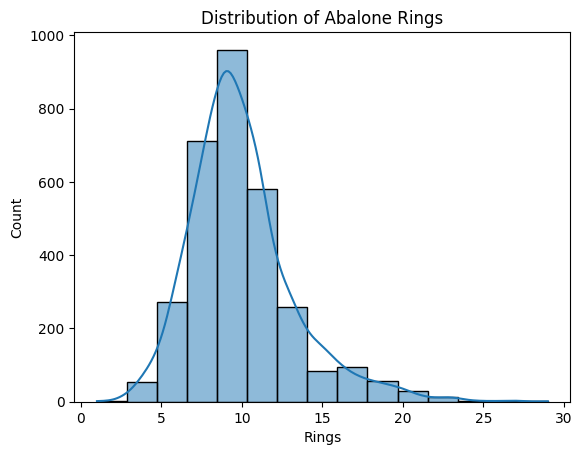

In [7]:
sns.histplot(y_train, bins=15, kde=True).set(title="Distribution of Abalone Rings")
plt.show()

It seems that Sex does not have a large difference on age but being an infant does.

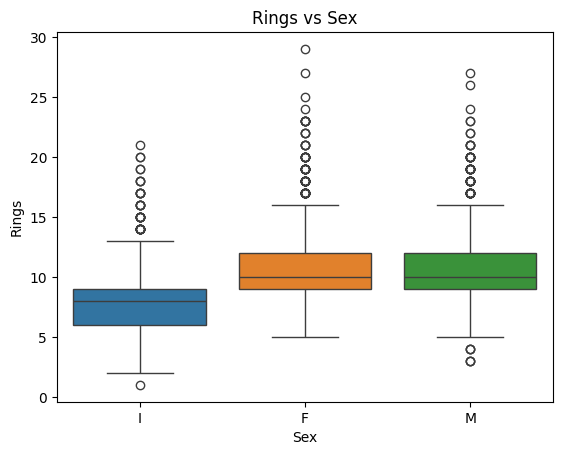

In [8]:
sns.boxplot(data=train_full, x="Sex", y="Rings", hue="Sex", legend=False)
plt.title("Rings vs Sex")
plt.xticks(ticks=[0, 1, 2])
plt.show()

The plots for Length, Diameter, and Height all look similar. The Length plot is seen below. In addition the weight features look similar between each 

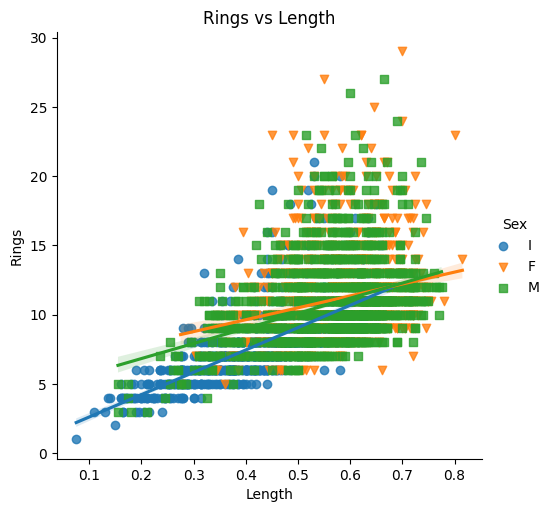

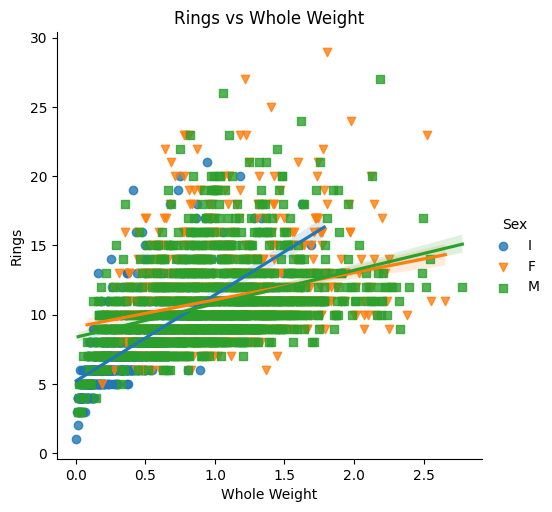

In [9]:
sns.lmplot(
    data=train_full, x="Length", y="Rings", hue="Sex", markers=["o", "v", "s"]
).set(title="Rings vs Length")
sns.lmplot(
    data=train_full, x="Whole_weight", y="Rings", hue="Sex", markers=["o", "v", "s"]
).set(title="Rings vs Whole Weight", xlabel="Whole Weight")

#### Colinearity 

Note that many of these features such as different mass or size measurements are highly correlated. This suggests I might want to use Ridge or Lasso to help with this. 

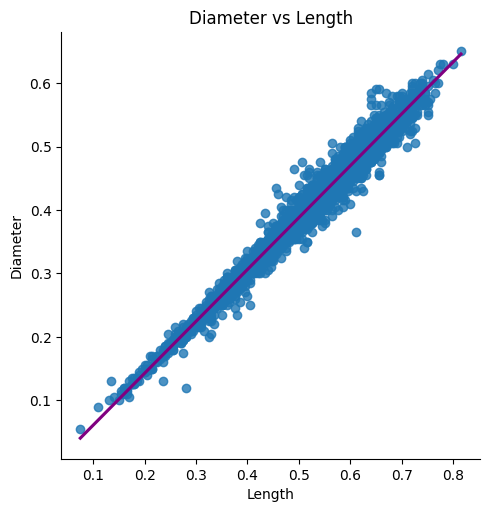

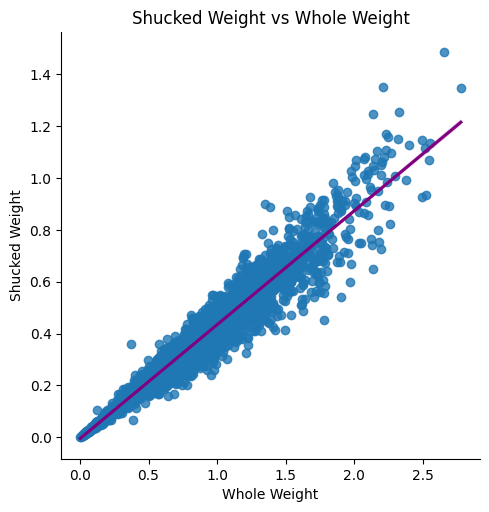

In [10]:
sns.lmplot(
    data=train_full, x="Length", y="Diameter", line_kws={"color": "purple"}
).set(title="Diameter vs Length")
sns.lmplot(
    data=train_full, x="Whole_weight", y="Shucked_weight", line_kws={"color": "purple"}
).set(title="Shucked Weight vs Whole Weight", xlabel="Whole Weight", ylabel="Shucked Weight")

### Feature Creation

The first feature I made was averaging the three length measurement. The next feature I am making is the avg_len_cubed as this is approximately proportional to the volume of the abalone. These distributions do look similar however to the length and mass feature from before. I also noticed there might be some association between the number of rings and the proportion of weight that is meat. 

In [11]:
def create_features(data):
    out = data.copy()
    out["avg_len"] = (out["Length"] + out["Diameter"] + out["Height"]) / 3
    out["avg_len_cubed"] = out["avg_len"] ** 3
    out["prop_shucked"] = out["Shucked_weight"] / out["Whole_weight"] 
    return out

train_adj = create_features(train_full)

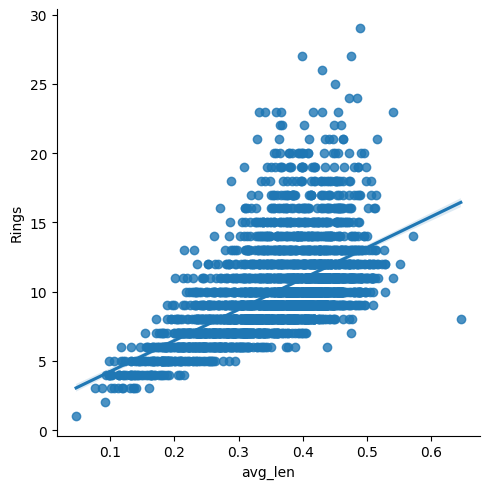

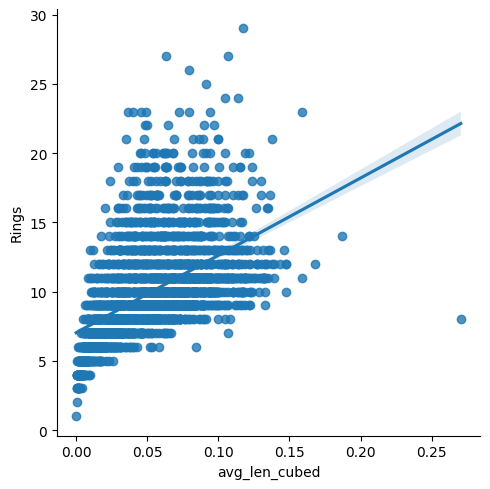

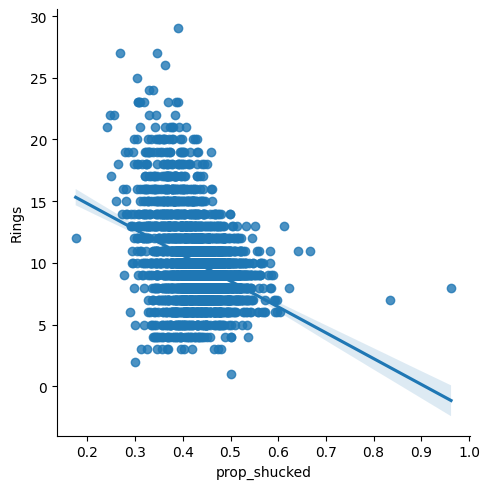

In [12]:
sns.lmplot(
    data=train_adj, x="avg_len", y="Rings"
)
sns.lmplot(
    data=train_adj, x="avg_len_cubed", y="Rings"
)
sns.lmplot(
    data=train_adj, x="prop_shucked", y="Rings"
)

## Modeling 

I am going to use Ridge, Lasso, ElasticNet, RandomForest, and Gradient Boosting

### Preprocessing 
I am first adding my custom features, then, I am encoding categorical features and standardizing my features.

In [13]:
add_features = FunctionTransformer(create_features)
scaler = StandardScaler()
oh_encoder = OneHotEncoder(sparse_output=False)
encoder = ColumnTransformer(transformers=[
    ("encoder", oh_encoder, ["Sex"])
], remainder="passthrough")

pipeline = Pipeline(steps=[
    ("new features", add_features),
    ("One Hot Encoder", encoder),
    ("scale", scaler)
]).set_output(transform="pandas")


X_train_scaled = pipeline.fit_transform(X_train)
X_test_scaled = pipeline.transform(X_test)

### Ridge

In [14]:
grid = GridSearchCV(
    Ridge(max_iter=1000), 
    {"alpha": 10 ** np.arange(-10, 10.5, 0.5)}, 
    scoring="neg_mean_squared_error"
)

grid.fit(X_train_scaled, y_train) 
ridge_model = grid.best_estimator_
print("MSE", -grid.best_score_)
print(ridge_model)

MSE 4.618272331515852
Ridge(alpha=np.float64(1.0), max_iter=1000)


### Lasso

In [15]:
grid = GridSearchCV(
    Lasso(max_iter=50000),
    {"alpha": 10 ** np.arange(-3, 3, 0.5)}, 
    scoring="neg_mean_squared_error"
)

grid.fit(X_train_scaled, y_train)
lasso_model = grid.best_estimator_
print("MSE", -grid.best_score_)
print(lasso_model)


MSE 4.619916379510036
Lasso(alpha=np.float64(0.001), max_iter=50000)


### Elastic Net

In [16]:
grid = GridSearchCV(
    ElasticNet(max_iter=20000),
    {"alpha": 10 ** np.arange(-3, 3, 0.5)}, 
    scoring="neg_mean_squared_error"
)

grid.fit(X_train_scaled, y_train)
elastic_model = grid.best_estimator_
print("MSE", -grid.best_score_)
print(elastic_model)

MSE 4.619408325608856
ElasticNet(alpha=np.float64(0.001), max_iter=20000)


### Random Forest

In [17]:
grid = GridSearchCV(
    RandomForestRegressor(random_state=123),
    {"n_estimators": [200, 300], "max_depth": [7, 9]}, 
    scoring="neg_mean_squared_error"
)

grid.fit(X_train_scaled, y_train)
forest_model = grid.best_estimator_
print("MSE", -grid.best_score_)
print(forest_model)

MSE 4.5505991261129575
RandomForestRegressor(max_depth=7, n_estimators=300, random_state=123)


In [18]:
grid = GridSearchCV(
    GradientBoostingRegressor(random_state=123, learning_rate=0.05),
    {"n_estimators": [100, 200, 300], "max_depth": [2, 3, 4]}, 
    scoring="neg_mean_squared_error"
)

grid.fit(X_train_scaled, y_train)
boost_model = grid.best_estimator_
print("MSE", -grid.best_score_)
print(boost_model)

MSE 4.506379678873394
GradientBoostingRegressor(learning_rate=0.05, max_depth=2, n_estimators=200,
                          random_state=123)


## Testing Models

It apears that the elastic net model has performed the best on the testing data. 

In [19]:
def test_model(model, X_test, y_test):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    print("MSE", mse)

print("Ridge")
test_model(ridge_model, X_test_scaled, y_test)
print("Lasso")
test_model(lasso_model, X_test_scaled, y_test)
print("ElasticNet")
test_model(elastic_model, X_test_scaled, y_test)
print("Forest")
test_model(forest_model, X_test_scaled, y_test)
print("Gradient Boosting")
test_model(boost_model, X_test_scaled, y_test)

Ridge
MSE 4.407261425876992
Lasso
MSE 4.407148950972643
ElasticNet
MSE 4.39951897584417
Forest
MSE 4.541117140265947
Gradient Boosting
MSE 4.4825965788060795
